In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lasagne
import theano
import theano.tensor as T
import seaborn as sns
from IPython import display
from lasagne.nonlinearities import *
from scipy.stats import multivariate_normal

%matplotlib inline

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 950M (0000:01:00.0)


In [18]:
# generator
G_input = T.matrix('G input')
G_layer = lasagne.layers.InputLayer((None, 5), G_input)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 2, nonlinearity=linear)
G = G_layer
G_out = lasagne.layers.get_output(G)

#discriminator
D_input = T.matrix('D input')
D_l1 = lasagne.layers.InputLayer((None, 2), D_input)
D_l2 = lasagne.layers.DenseLayer(D_l1, 10, nonlinearity=tanh)
D_l3 = lasagne.layers.DenseLayer(D_l2, 10, nonlinearity=tanh)
D_l4 = lasagne.layers.DenseLayer(D_l3, 1, nonlinearity=sigmoid)
D = D_l4
D_out = lasagne.layers.get_output(D)

DG_l1 = lasagne.layers.InputLayer((None, 2), G_out)
DG_l2 = lasagne.layers.DenseLayer(DG_l1, 10, nonlinearity=tanh, W=D_l2.W, b=D_l2.b)
DG_l3 = lasagne.layers.DenseLayer(DG_l2, 10, nonlinearity=tanh, W=D_l3.W, b=D_l3.b)
DG_l4 = lasagne.layers.DenseLayer(DG_l3, 1, nonlinearity=sigmoid, W=D_l4.W, b=D_l4.b)
DG = DG_l4
DG_out = lasagne.layers.get_output(DG)


D_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
D_weights = lasagne.layers.get_all_params(D)
D_loss = - (T.log(D_out) + T.log(1 - DG_out)).mean()
D_updates = lasagne.updates.nesterov_momentum(D_loss, D_weights, learning_rate=D_lr, momentum=0.)
D_train = theano.function([D_input, G_input],D_loss, updates=D_updates)
# D_acc = lasagne.objectives.categorical_accuracy()

G_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
G_weights = lasagne.layers.get_all_params(G)
G_loss = - T.log(DG_out).mean()
G_updates = lasagne.updates.nesterov_momentum(G_loss, G_weights, learning_rate=G_lr, momentum=0.)
G_train = theano.function([G_input], G_loss, updates=G_updates)

# output functions
discriminate = theano.function([G_out], DG_out)
generate = theano.function([G_input], G_out)

In [19]:
G_lr.set_value(0.05)
D_lr.set_value(0.05)

In [20]:
def sample_noise(M=200):
    mean, cov = [0, 0], [(1,0), (0, 1)]
#     z = np.random.multivariate_normal(mean, cov, M)
    z = np.random.normal(0,1,M)
    z = np.random.uniform(-1,1,size=(M,5))
    return z.astype(theano.config.floatX)

In [21]:
mean, cov = [3, 4], [(0.5,0), (-0.5, 2)]
def true_input(M=200):
    x = np.random.multivariate_normal(mean, cov, M)
    return x.astype(theano.config.floatX)

In [28]:
def plot_fig(generate=None, discriminate=None):
    plt.figure(figsize=(10,10))
    r = 300 # resolution (number of points)
    
    # plot in0put
#     xs = true_input(r)
#     sns.kdeplot(xs.T[0], xs.T[1], shade=True, shade_lowest=False, cmap='Greens')
    plt.axis([-3,10,-3,10])
    x, y = np.mgrid[-3:10:.1, -3:10:.1]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    plt.contourf(x, y, rv.pdf(pos), cmap='Greens')
    #plot generator output
    zs = sample_noise(r)
    zs = generate(zs)
    sns.kdeplot(zs.T[0], zs.T[1], cmap='coolwarm', n_levels=3)
    plt.scatter(zs.T[0], zs.T[1], c='orange', marker='+')
    plt.axis('normal')

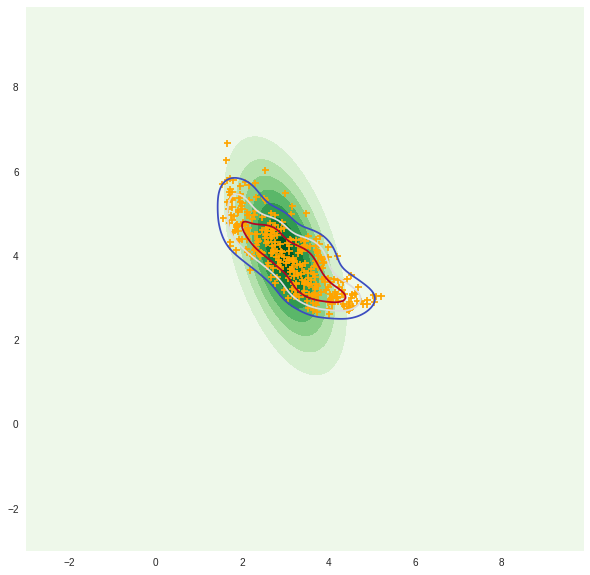

In [29]:
plot_fig(generate)

In [30]:
epochs = 50
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20
M = 200
visualize_training = True  # set to True to monitor training progress

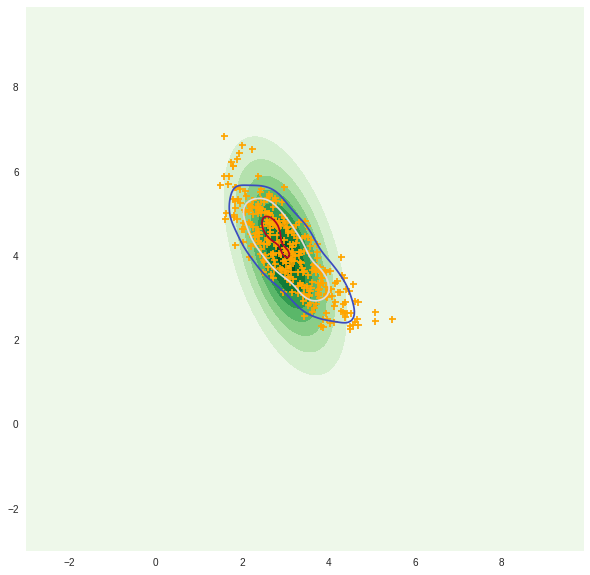

In [33]:
plt.ion()
c = 0
for i in range(2):
    for j in range(k):
        x = true_input(M)  # sampled m-batch from p_data
        z = sample_noise(M)  # sample m-batch from noise prior
        histd[i] = D_train(x, z)
    z = sample_noise(M)
    histg[i] = G_train(z)
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
    if visualize_training and c > 0:
#         plt.clf()
        plot_fig(generate, discriminate)
        display.clear_output(wait=True)
        plt.show()
        c = 0
    c = c + 1